In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from layers.Embed import DataEmbedding
from layers.Conv_Blocks import Inception_Block_V1
from models import TimesNet, TimeMixer
from data_provider import data_factory

# config

In [32]:

class Config:
    def __init__(self):
        # Basic config
        self.task_name = "long_term_forecast"
        self.is_training = 1
        self.model_id = "test"

        # Data loader
        self.data = "ETTm1"
        self.root_path = "dataset\ETT-small"
        self.data_path = "ETTh1.csv"
        self.features = "M"  # Options: [M, S, MS]
        self.target = "OT"
        self.freq = "h"
        self.checkpoints = "./checkpoints/"

        # Forecasting task
        self.seq_len = 96
        self.label_len = 0
        self.pred_len = 96
        self.seasonal_patterns = "Monthly"
        self.inverse = False

        # # Imputation task
        # self.mask_rate = 0.25

        # # Anomaly detection task
        # self.anomaly_ratio = 0.25

        # Model definition
        self.expand = 2
        self.d_conv = 4
        self.top_k = 3
        self.num_kernels = 2
        self.enc_in = 7
        self.dec_in = 7
        self.c_out = 7
        self.d_model = 32
        self.n_heads = 8
        self.e_layers = 2
        self.d_layers = 1
        self.d_ff = 128
        self.moving_avg = 25
        self.factor = 3
        self.distil = True
        self.dropout = 0.1
        self.embed = "timeF"  # Options: [timeF, fixed, learned]
        self.activation = "gelu"
        self.channel_independence = 1  # 0: channel dependence, 1: channel independence
        self.decomp_method = "moving_avg"  # Options: [moving_avg, dft_decomp]
        self.use_norm = 1
        self.seg_len = 48

        # Optimization
        self.num_workers = 0
        self.itr = 1
        self.train_epochs = 1
        self.batch_size = 2
        self.patience = 3
        self.learning_rate = 0.0001
        self.des = "test"
        self.loss = "MSE"
        self.lradj = "type1"
        self.use_amp = False

        # GPU
        self.use_gpu = False
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = "0,1,2,3"

        # De-stationary projector parameters
        self.p_hidden_dims = [128, 128]
        self.p_hidden_layers = 2

        # Metrics (DTW)
        self.use_dtw = False

        # Augmentation
        self.augmentation_ratio = 0
        self.seed = 2
        self.jitter = False
        self.scaling = False
        self.permutation = False
        self.randompermutation = False
        self.magwarp = False
        self.timewarp = False
        self.windowslice = False
        self.windowwarp = False
        self.rotation = False
        self.spawner = False
        self.dtwwarp = False
        self.shapedtwwarp = False
        self.wdba = False
        self.discdtw = False
        self.discsdtw = False
        self.extra_tag = ""

        # TimeXer
        self.patch_len = 16

        # TimeMixer
        self.down_sampling_layers = 3
        self.down_sampling_window = 2
        self.down_sampling_method = "avg"  # Options: [avg, max, conv]

config = Config()

# dataset

In [33]:
dataset, data_loader = data_factory.data_provider(config, flag='train')
print("simpler:" + str(len(dataset)))
# batch_x, batch_y, batch_x_mark, batch_y_mark = dataset[0]

# print("a simpler like:",batch_x.shape, batch_x_mark.shape, batch_y.shape, batch_y_mark.shape)
# print(batch_x.dtype)

data_iter = iter(data_loader)
batch_x, batch_y, batch_x_mark, batch_y_mark = next(data_iter)
batch_x = batch_x.to(torch.float32)
batch_y = batch_y.to(torch.float32)
batch_x_mark = batch_x_mark.to(torch.float32)
batch_y_mark = batch_y_mark.to(torch.float32)
print("a simpler like:",batch_x.shape, batch_x_mark.shape, batch_y.shape, batch_y_mark.shape)
print(batch_x.dtype)
    

train 17229
simpler:17229
a simpler like: torch.Size([2, 96, 7]) torch.Size([2, 96, 4]) torch.Size([2, 96, 7]) torch.Size([2, 96, 4])
torch.float32


# model

In [34]:
model = TimeMixer.Model(config)

In [35]:
print(model, model(batch_x, batch_x_mark, batch_y, batch_y_mark).shape)


Model(
  (pdm_blocks): ModuleList(
    (0-1): 2 x PastDecomposableMixing(
      (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (decompsition): series_decomp(
        (moving_avg): moving_avg(
          (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
        )
      )
      (mixing_multi_scale_season): MultiScaleSeasonMixing(
        (down_sampling_layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=96, out_features=48, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=48, out_features=48, bias=True)
          )
          (1): Sequential(
            (0): Linear(in_features=48, out_features=24, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=24, out_features=24, bias=True)
          )
          (2): Sequential(
            (0): Linear(in_features=24, out_features=12, bias=True)
            


(process:11592): Pango-WARNING **: 05:36:18.875: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:15032): Pango-WARNING **: 05:36:20.152: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


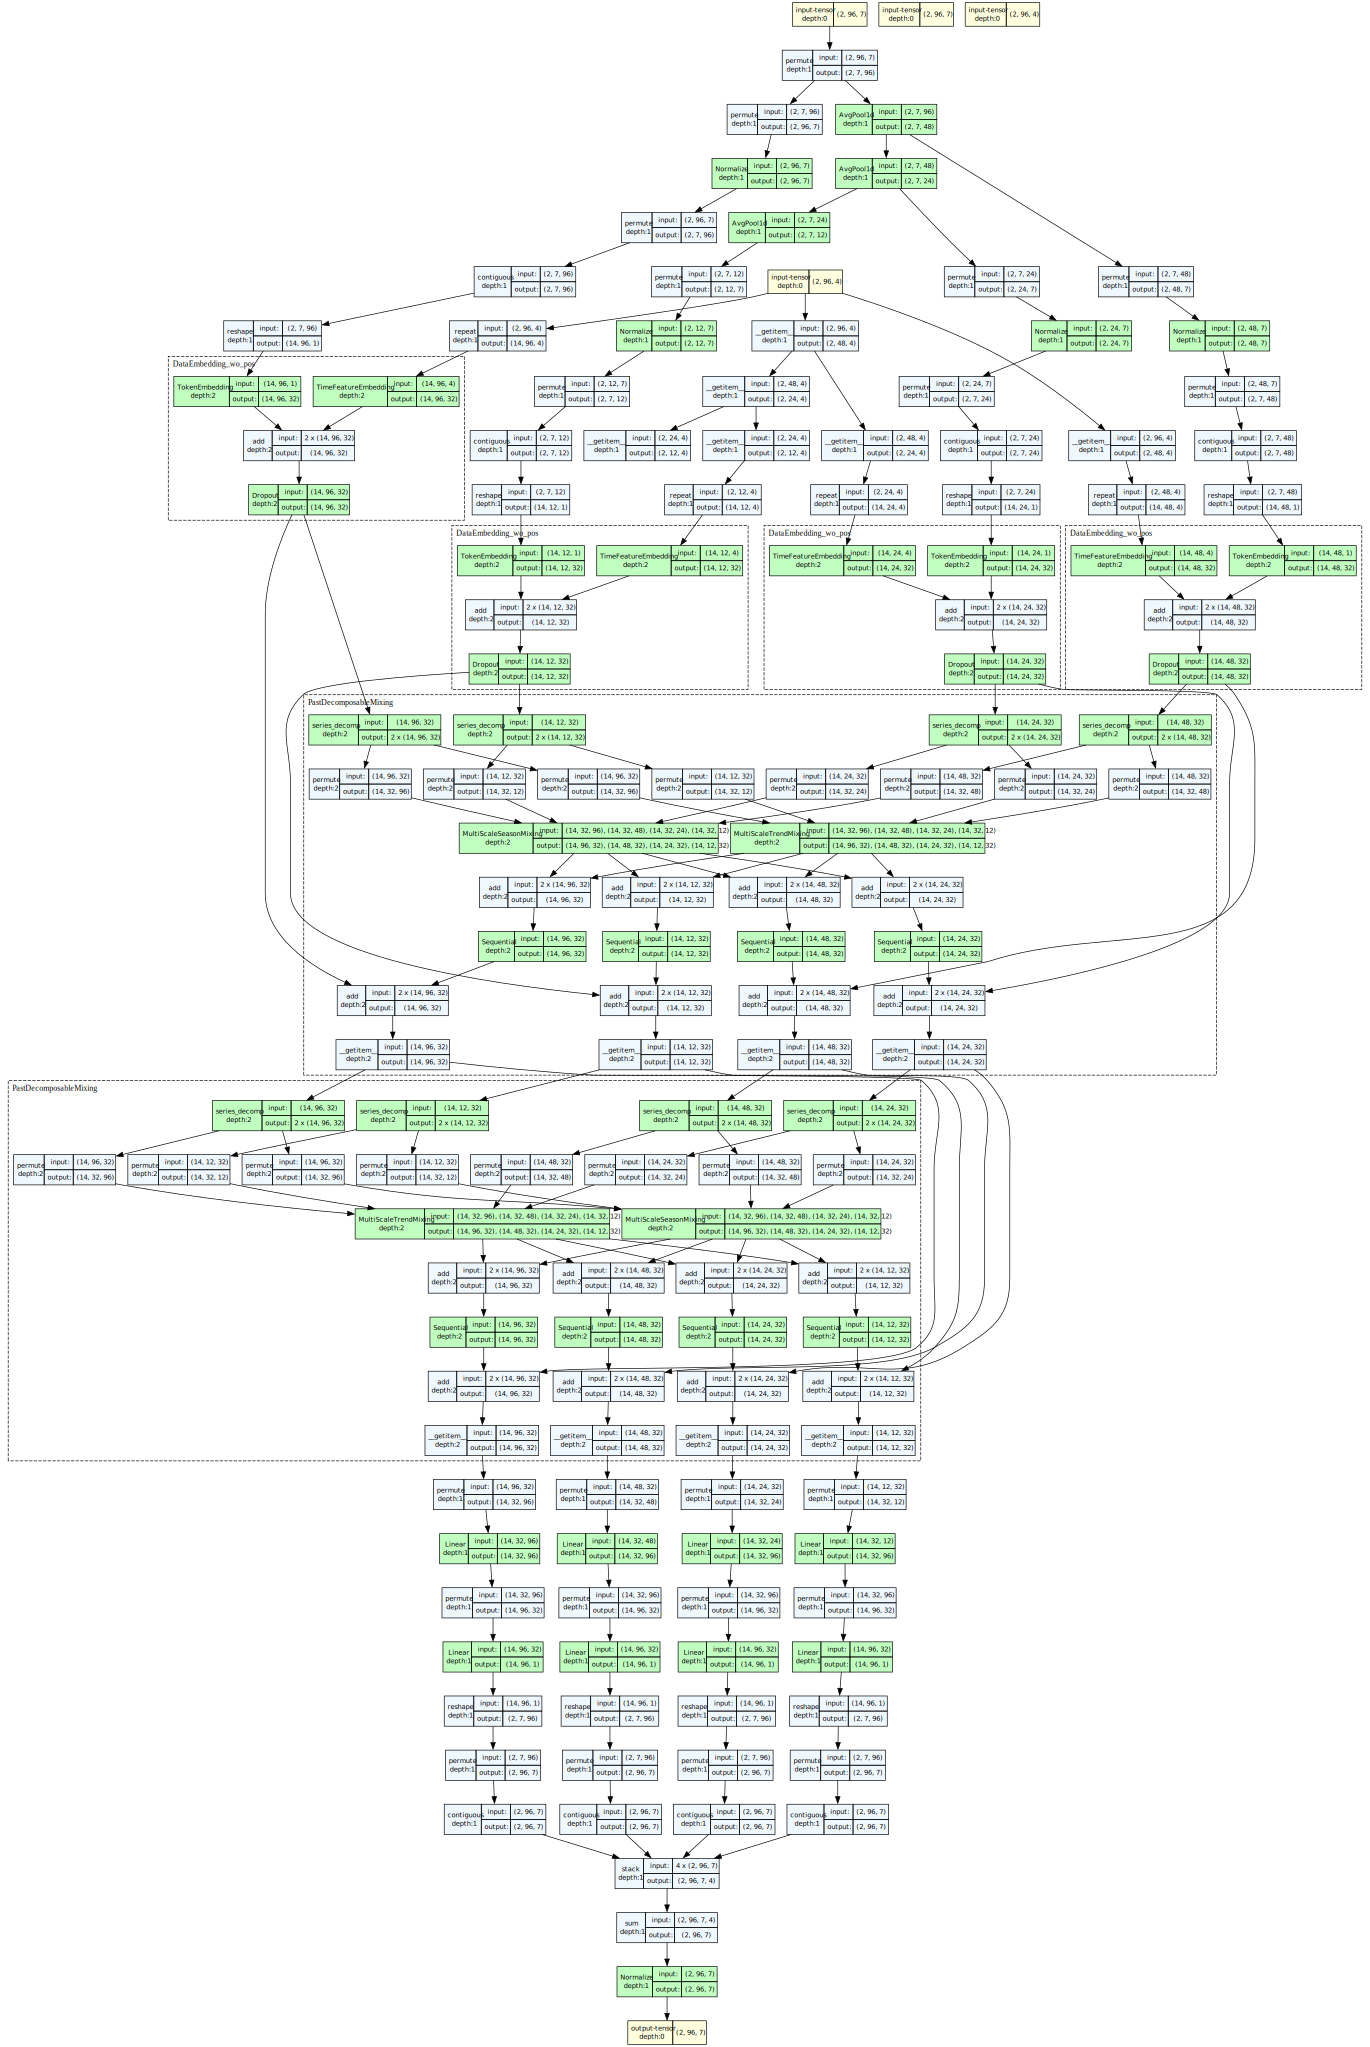

In [36]:
from torchview import draw_graph

model_graph = draw_graph(model=model, input_data=(batch_x, batch_x_mark, batch_y, batch_y_mark), depth=2, expand_nested = True,save_graph=True, filename="torchview", directory="./model_view")

model_graph.visual_graph

In [37]:
from torchinfo import summary
print(config.seq_len, config.label_len, config.pred_len)
print("a simpler like:",batch_x.shape, batch_x_mark.shape, batch_y.shape, batch_y_mark.shape)
summary(model=model, input_data=(batch_x, batch_x_mark, batch_y, batch_y_mark), col_names=["input_size",
                    "output_size",
                    "kernel_size",],depth=8)

96 0 96
a simpler like: torch.Size([2, 96, 7]) torch.Size([2, 96, 4]) torch.Size([2, 96, 7]) torch.Size([2, 96, 4])


Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape
Model                                         [2, 96, 7]                [2, 96, 7]                --
├─ModuleList: 1-15                            --                        --                        --
│    └─Normalize: 2-1                         [2, 96, 7]                [2, 96, 7]                --
│    └─Normalize: 2-2                         [2, 48, 7]                [2, 48, 7]                --
│    └─Normalize: 2-3                         [2, 24, 7]                [2, 24, 7]                --
│    └─Normalize: 2-4                         [2, 12, 7]                [2, 12, 7]                --
├─DataEmbedding_wo_pos: 1-2                   [14, 96, 1]               [14, 96, 32]              --
│    └─TokenEmbedding: 2-5                    [14, 96, 1]               [14, 96, 32]              --
│    │    └─Conv1d: 3-1                       [14, 1, 96]               [14, 32, 